Check [Week 3 challenge description](../../challenges/week3.md) if you missed the required setup steps for this week.

**👉 Note that this notebook has typos and errors that you need to fix as a part of the challenge.**

In [1]:
import os

## Preview the machine-generated images of pets

You will be working on a set of machine-generated images of the most popular (again, accordingly to the GenAI) breeds of cats and dogs. Images are stored in the folder [../data/pets/](../data/pets/) 

In [2]:
from PIL import Image as PILImage
from IPython.display import display

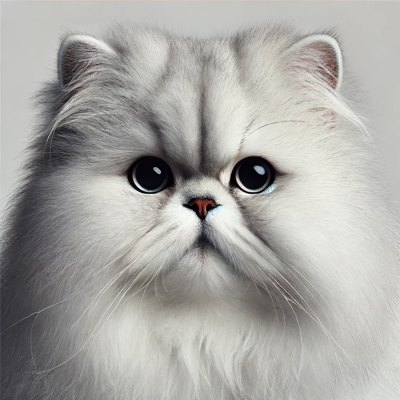

In [3]:
dir_images='../data/pets/'

img = PILImage.open(dir_images+'25_Persian.webp') #21_Ragdoll.webp
display(img.resize((400, 400)))

## Get image [embeddings](https://help.sap.com/docs/hana-cloud-database/sap-hana-cloud-sap-hana-database-vector-engine-guide/vectors-vector-embeddings-and-metrics)

You will use `ResNet50V2` model from https://keras.io/api/applications/#available-models to get embeddings of the images.

Ignore possible information `I` and warning `W` messages from the first `tensorflow` import below.

In [5]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.preprocessing import image as tf_image

import pandas as pd
import numpy as np
from tqdm.auto import tqdm

In [6]:
mymodel = ResNet50V2(include_top=False, weights='imagenet', pooling='avg')

The model ResNet50V2 will be downloaded during the first instantiation to the folder `~/.keras/models/`.

In [7]:
!ls -lh ~/.keras/models/

total 91M
-rw-r--r-- 1 user group 91M Jun 20 10:52 resnet50v2_weights_tf_dim_ordering_tf_kernels_notop.h5


To speed up processing a bit you will reduce the size of the images by half `1024//2`. Please note the use of `//` to have integer number as a result.

In [8]:
#Function to get embeddings

def get_image_embedding(model, img_path):
    img = tf_image.load_img(img_path, target_size=(1024//2, 1024//2))
    #display(img.resize((400, 400)))
    x = tf_image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    embeddings = model.predict(x)  
    result = pd.DataFrame(embeddings[0]).T
    return result

Get embeddings for all images in the source directory and store them in the `embedding_df` Pandas DataFrame for now.

In [9]:
dir_images='../data/pets/'

path_images = os.listdir(dir_images)
embedding_df = pd.DataFrame()
for current_img in tqdm(path_images):
    curr_df = get_image_embedding(model=mymodel, img_path=dir_images+current_img)    
    curr_df['image'] = current_img
    embedding_df = pd.concat([embedding_df, curr_df], ignore_index=True)

  0%|          | 0/19 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


In [12]:
# Check one of the generated embeddings
display(embedding_df.iloc[2])

# Note 2048 fileds with real numbers for dimensions from 0 to 2047, plus the file name in the last field.

0                 0.069521
1                 0.019587
2                 0.250141
3                 0.007758
4                 0.063438
               ...        
2044              0.019501
2045                   0.0
2046              0.142452
2047                   0.0
image    19_Dachshund.webp
Name: 2, Length: 2049, dtype: object

## Upload into your SAP HANA database

...similarly to how you uploaded word vectors during the Week 2 exercise.

In [13]:
os.environ["HDB_USE_IDENT"]=os.getenv("WORKSPACE_ID")
print(os.getenv("HDB_USE_IDENT"))

workspaces-ws-cwf68


In [14]:
from hana_ml import dataframe as hdf

In [15]:
myconn=hdf.ConnectionContext(userkey='myDevChallenger')
print("SAP HANA DB version: ", myconn.hana_version())

SAP HANA DB version:  4.00.000.00.1718101422 (fa/CE2024.2)


In [16]:
source_table="IMAGES"

In [17]:
myconn.connection.setautocommit(True)
mycursor = myconn.connection.cursor()

try:
    mycursor.execute(f'DROP TABLE {source_table}')
    myconn.connection.commit()

except Exception as e:
    # Handle any exceptions and possibly rollback the transaction
    myconn.connection.rollback()
    print("An error occurred:", e)

The table `IMAGES` will store:
- a file name in `"IMAGE_NAME"`
- a breed name in `"NAME"`
- an **i**mage embedding (or **v**ector) in `"IV"`
- a Base64-encoded image of a pet in `"IMAGE"`

In [18]:
myconn.create_table(
    source_table, 
    table_structure={
        "IMAGE_NAME": "NVARCHAR(50)", 
        "NAME": "NVARCHAR(50)", 
        "IV": "REAL_VECTOR(2048)",
        "IMAGE": "NCLOB"
        }
    )

## Get image Base64 encodings to be stored in the database table 

In [19]:
from io import BytesIO
import base64

In [20]:
# Function to open and encode an image to Base64
def get_image_encoding(image_path, size=(400, 400)):
    img_resized = PILImage.open(image_path).resize(size)
    buffer = BytesIO()
    img_resized.save(buffer, format="WEBP")
    encoded_img = base64.b64encode(buffer.getvalue()).decode('utf-8')
    return encoded_img


In the next cell, prepare the list of records `myrecords_to_insert` to be inserted into the database.

Each record has 4 fields with:
- a file name: `[myrow[-1:][0]`
- a breed name derived from a file name: `myrow[-1:][0].split('.')[0].split('_')[1]`
- image encoding: `get_image_encoding(dir_images+myrow[-1:][0])` for an image read from the file name
- a string representation of a vector embedding `str(myrow[:-1])`

In [24]:
%%time
my_embeddings=embedding_df.values.tolist()

myrecords_to_insert=[
    [myrow[-1:][0], 
    myrow[-1:][0].split('.')[0].split('_')[1], 
    get_image_encoding(dir_images+myrow[-1:][0]), 
    str(myrow[:-1])] 
    for myrow in my_embeddings]

CPU times: user 919 ms, sys: 7.51 ms, total: 926 ms
Wall time: 926 ms


In [27]:
#Display one of the records to see its all 4 fields
display(myrecords_to_insert[3])

['28_ScottishFold.webp',
 'ScottishFold',
 'UklGRgZmAABXRUJQVlA4IPplAABQYwGdASqQAZABPm0wk0YkIyGhrBWsAIANiWduiUmMBPG6yW66Z8eovWFWoG3EHmA/WD1ePSL/mPS3yZPyVcHG9I/l+8/80+v/cD6OWH/tg1DvJf/l61v7nvX+fuoRjF2FF1PQUwf8Ff4r1A/NH/2+FP7J7AvlI/83kh/d/+t7CHl6///3a/vH///+18Pn7jf/9HzK2mzOeXRuxrcNMJuGDOchK+PQRBGCCrTwSw7CD/qCWdhDEtZDql+dstcmxeMjKSO4yakhiYNj7j5te3H23npo6ZLc77jiVErvRY9njLK2qL+fgWzDCqTH8B4LS+N1vf44srlzGy3xwEKsnAFdeyfuEFRk6MvH6Q53MOrO+ho9QZGMzieZtYR/JgbtuoIfnvh1aQmwkN2lElcAqpDYMmx5uI8YF9MXHLADqHIjmykOfoHm4ELw8Mizzq1O49CDvyIkeBDNtqGKGadBHKH5OnIAfjDyFZhRlZJUNdekxbRjpeiPlGhGSyDuZaQtGz51MEg8s8TLNrEH2OvIlXs5G8FCEMCyjvTZCteO9YLbckFn0cmJ1Do2K+0VYVmRQ83+8IpNrMbbdPy7G8+0jKpEjRs7V0UfMXjiLG7JZo045k9JnttfsXVhmK7DDupkarfx9yJNmqihu8gOv9R2mx8FCVSaxp9rb8m1VT+d4JwbvrMAs4XgCx2mVJLVDlHsznex0YDC8Ujixm0cgmXerq+ikTxb4150vFRi8Grn+qODeqTtcQsKHWucdm7VK6zCHJGsGvRUIbIQdu0Lys2THnYewu9x09D13cxjQ3CMlG0fNo6jkfXLOrpFw8MVQ4s0bMBTvHjCtbL3agZUQb6SACZav2kwCqpwi2BSlO9MeQkLgdwbY9RTW3Jj+yu8heZ8Wq05hbDUDB9cixG8SXgt3vD7h8GnBURztqaA

In [28]:
%%time
myconn.connection.setautocommit(False)
cursor = myconn.connection.cursor()

try:
    mycursor.execute(f'TRUNCATE TABLE {source_table}')
    # Use the executemany method to insert the data
    cursor.executemany(f'''INSERT INTO {source_table} ("IMAGE_NAME", "NAME", "IMAGE", "IV") VALUES (?, ?, ?, TO_REAL_VECTOR(?))''', 
        myrecords_to_insert
    )

except Exception as e:
    # Handle any exceptions and possibly rollback the transaction
    myconn.connection.rollback()
    print("An error occurred:", e)

CPU times: user 7.68 ms, sys: 279 μs, total: 7.96 ms
Wall time: 44.8 ms


In [29]:
%%time
try:
    # Commit the transaction to save the changes
    myconn.connection.commit()

finally:
    # Close the cursor and the connection when done
    cursor.close()

CPU times: user 702 μs, sys: 54 μs, total: 756 μs
Wall time: 5.77 ms


## Check data in the database table

In [52]:
## Check the size of the table in the database
print(f"Number of records in the table {source_table}: {myconn.table(table=source_table).count()}")

Number of records in the table IMAGES: 19


In [30]:
## Display a record for one of the entries
word='MaineCoon'

sql = f'''
SELECT "A".* FROM {source_table} AS "A"
WHERE "A"."NAME"='{word}'
'''

hdf = myconn.sql(sql)
print(hdf.select_statement)
hdf.head(3).collect()


SELECT "A".* FROM IMAGES AS "A"
WHERE "A"."NAME"='MaineCoon'


,IMAGE_NAME,NAME,IV,IMAGE
0,22_MaineCoon.webp,MaineCoon,"[0, 8, 0, 0, 140, 242, 20, 60, 56, 219, 150, 6...",UklGRlCGAABXRUJQVlA4IESGAACwlQGdASqQAZABPmkqkE...


Note that the `"IV"` column is binary and can be represented in different formats in different database client tools, as mentioned by Dirk O. in his comment: https://community.sap.com/t5/application-development-discussions/questions-re-quot-multi-model-with-sap-hana-cloud-quot-developer-challenge/m-p/13732043/highlight/true#M2028526

It is only when transofrmed to the string with [`TO_NVARCHAR()`](https://help.sap.com/docs/hana-cloud-database/sap-hana-cloud-sap-hana-database-vector-engine-guide/to-nvarchar-function-data-type-conversion?version=2024_1_QRC&locale=en-US) then you can see its vector representation.

In [31]:
## Display a record for one of the entries
word='MaineCoon'

sql = f'''
SELECT TO_VARCHAR("IV") FROM {source_table} AS "A"
WHERE "A"."NAME"='{word}'
'''

hdf = myconn.sql(sql)
print(hdf.select_statement)

pd.set_option('display.max_colwidth', 180)
display(hdf.head(3).collect())

pd.set_option('display.max_colwidth', 80)


SELECT TO_VARCHAR("IV") FROM IMAGES AS "A"
WHERE "A"."NAME"='MaineCoon'


,TO_NVARCHAR(IV)
0,"[0.009091031,0.073660314,1.5812377,0.50656027,0.022206647,0.013695891,0.023843262,0.044057433,0.017793775,0.0018956219,0,0,0,0.14753982,0.0018018829,0.7582599,0.0020961184,0.01..."
